In [126]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import pandas as pd
import numpy as np
import json
from datetime import date, datetime
import logging
from elastic_util import *
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [127]:
logger = logging.getLogger('psychosis_risk_cal')
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s : %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# 1. Read test data

In [128]:
test_df = pd.read_excel('data/test_data.xlsx')

In [129]:
test_df.shape

(120, 55)

# 1.1 Original calculation is only for patients whose ages are large than 16

In [130]:
test_df['index_diagnosis_date'] = pd.to_datetime(test_df['index_diagnosis_date'], errors='coerce').dt.date

In [148]:
min_date = min(test_df['index_diagnosis_date'])

In [149]:
max_date = max(test_df['index_diagnosis_date'])

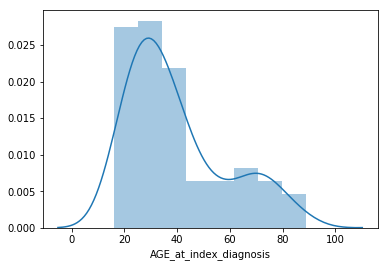

In [132]:
sns.distplot(test_df['AGE_at_index_diagnosis'])
plt.show()

In [133]:
min(test_df['AGE_at_index_diagnosis'])

16

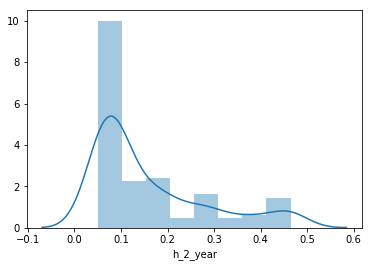

In [134]:
sns.distplot(test_df['h_2_year'])
plt.show()

# 2. Read data from Cogstack

In [135]:
logger.info('Connect to host.....')
client = Elasticsearch(['http://10.16.31.65:9200/'], request_timeout=600)
doc_type='doc'
index = 'psychosis_risk'
s = Search(using=client, index=index, doc_type=doc_type).filter('range', h_2_year={'gte': 0.05})
logger.info('Loaded %s documents' %s.count())
df = pd.DataFrame((d.to_dict() for d in s.scan()))
logger.info('Documents shape: %s %s' %(df.shape))

logger.info('Change data types')
#     df['first_primary_diagnosis_date'] = pd.to_datetime(df['first_primary_diagnosis_date'])
#     df['patient_date_of_birth'] = pd.to_datetime(df['patient_date_of_birth'])
#     df['first_primary_diagnosis_recorded_date'] = pd.to_datetime(df['first_primary_diagnosis_recorded_date'])
#     print(df.dtypes)
#     df['patient_id'] = df['patient_id'].astype(int)
#     df['referral_id'] = df['referral_id'].astype(int)
logger.info('Documents shape after changing data types: %s %s' %(df.shape))

2019-05-17 23:11:06,544 psychosis_risk_cal INFO     : Connect to host.....
2019-05-17 23:11:06,544 psychosis_risk_cal INFO     : Connect to host.....
2019-05-17 23:11:06,544 psychosis_risk_cal INFO     : Connect to host.....
2019-05-17 23:11:06,544 psychosis_risk_cal INFO     : Connect to host.....
2019-05-17 23:11:06,544 psychosis_risk_cal INFO     : Connect to host.....
2019-05-17 23:11:06,544 psychosis_risk_cal INFO     : Connect to host.....
2019-05-17 23:11:06,562 psychosis_risk_cal INFO     : Loaded 6926 documents
2019-05-17 23:11:06,562 psychosis_risk_cal INFO     : Loaded 6926 documents
2019-05-17 23:11:06,562 psychosis_risk_cal INFO     : Loaded 6926 documents
2019-05-17 23:11:06,562 psychosis_risk_cal INFO     : Loaded 6926 documents
2019-05-17 23:11:06,562 psychosis_risk_cal INFO     : Loaded 6926 documents
2019-05-17 23:11:06,562 psychosis_risk_cal INFO     : Loaded 6926 documents
2019-05-17 23:11:07,296 psychosis_risk_cal INFO     : Documents shape: 6926 34
2019-05-17 23:1

In [136]:
df.shape

(6926, 34)

# 3. Records missed in Cogstack

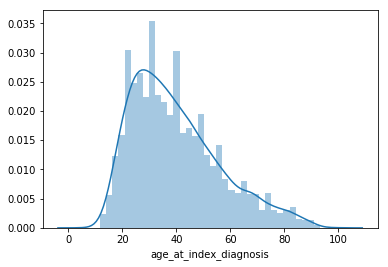

In [137]:
sns.distplot(df['age_at_index_diagnosis'])
plt.show()

In [138]:
min(df1['age_at_index_diagnosis'])

5.0

In [139]:
df1[df1['age_at_index_diagnosis']==5]

,PI,age_at_index_diagnosis,age_coeff,alerted,alerted_dttm,coeff_validated,diagnosis_group,diagnosis_group_coeff,diagnosis_invalid_flag,diagnosis_updated_dttm,...,icd10_id,patient_date_of_birth,patient_demography_ethnicity,patient_demography_ethnicity_cris,patient_demography_gender,patient_id,patient_name,patient_other_id1,patient_updated_dttm,risk_calculated_dttm
2857,2.083192,5.0,0.058556,False,2019-05-17T23:02:04.767828,1,Acute and transient psychotic disorders,0.98672,0,2017-02-17T12:46:20.410,...,767485,2011-11-01T00:00:00,Other African (N),african (n),Female,444276,Miss Frances Hannah Fofanah,56-94-51,2017-02-06T16:42:05.100,2019-05-17T23:02:04.108919


In [140]:
set(test_df['Other_ID1']) - set(df['patient_other_id1'])

{datetime.datetime(1943, 1, 24, 0, 0),
 datetime.datetime(1998, 1, 24, 0, 0),
 '59-64-19',
 '61-27-69'}

## There are 4 records are missed in Cogstack, 

## where 2 have mistakes in Other_ID1, so these 2 records cannot be tracked back.

## Reason for the other 2 missed records (i.e., patients with "Other_ID1" of '59-64-19' and '61-27-69'): 

## Original calculation did not exclude invalid diagnosis, see the "index_primary_diagnosis" filed in the Excel file. The "index_primary_diagnosis" of these patients in the Excel file are "F31.3 - Bipolar affect disorder cur epi mild or moderate depression" and "F30.1 - Mania without psychotic symptoms", the same as the Primary_Diag of these patients' invalid diagnoses.

## Below is the diagnoses of these two patients from ePJS. The first Primary_Diag of these two patients are invalid, so they are excluded in Cogstack-based calculations.

|Patient_ID|Other_ID1|
|----------|---------|
|471259|59-64-19|


|ICD10_ID|Patient_ID|Diagnosis_Date|Created_Date|dnum|Primary_Diag|Invalid_Flag_ID|Invalid_Date|Invalid_Reason|
|--------|----------|--------------|------------|----|------------|---------------|------------|--------------|
|833975|471259|2018-03-19|2018-03-19|1|F31.3 - Bipolar affect disorder cur epi mild or moderate depression|1|2018-04-10 00:00:00|Wrong diagnosis entered erroneously |
|837500|471259|2018-04-10|2018-04-10|2|F32.1 - Moderate depressive episode|0|||
|862940|471259|2018-08-28|2018-08-28|3|F33.4 - Recurrent depressive disorder, currently in remission|0|||



|Patient_ID|Other_ID1|
|----------|---------|
|487618|61-27-69|


|ICD10_ID|Patient_ID|Diagnosis_Date|Created_Date|dnum|Primary_Diag|Invalid_Flag_ID|Invalid_Date|Invalid_Reason|
|--------|----------|--------------|------------|----|------------|---------------|------------|--------------|
|875441|487618|2018-11-09|2018-11-09|1|F30.1 - Mania without psychotic symptoms|1|2018-11-09 00:00:00||
|875442|487618|2018-11-09|2018-11-09|2|F30.2 - Mania with psychotic symptoms|0|||
|882163|487618|2018-12-12|2018-12-12|3|F30.2 - Mania with psychotic symptoms|0|||
|887016|487618|2019-01-12|2019-01-12|4|F30.2 - Mania with psychotic symptoms|0|||
|888452|487618|2019-01-21|2019-01-21|5|F30.2 - Mania with psychotic symptoms|0|||
|889448|487618|2019-01-25|2019-01-25|6|F30.2 - Mania with psychotic symptoms|0|||
|890244|487618|2019-01-30|2019-01-30|7|F30.2 - Mania with psychotic symptoms|0|||
|890914|487618|2019-01-30|2019-02-02|8|F30.2 - Mania with psychotic symptoms|0|||



# 4. Check differences of risk scores

In [141]:
common_ids = set(test_df['Other_ID1']).intersection(set(df['patient_other_id1']))

In [142]:
len(common_ids)

116

In [143]:
orig_fields = ['Gender_co_ef', 'Age_co_ef', 'diagnosis_group_co_ef', 'Eth_co_ef', 'GenderAge']
cog_fields = ['gender_coeff', 'age_coeff', 'diagnosis_group_coeff', 'eth_coeff', 'gender_age_coeff']
flen = len(orig_fields)

## 4.1 Check different of PI

In [144]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['PI'].values[0]
    cog = df[df['patient_other_id1'] == id]['PI'].values[0]
    if abs(orig - cog) > 0.00001:
        mis_count += 1
        print(str(id) + ' is different on PI values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.00001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

49-70-14 is different on PI values: 1.5722854   1.5308083000000001
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
56-85-16 is different on PI values: 0.5606118   0.1525082
	eth_coeff is different:  0.4081036   0.0
2


|patient_id|patient_updated_dttm|patient_name|patient_other_id1|patient_date_of_birth|patient_demography_gender|patient_demography_ethnicity|
|----------|--------------------|------------|-----------------|---------------------|-------------------------|----------------------------|
|443341|2019-01-02 11:44:32|Ms Alisha Rouse|56-85-16|1990-11-21|Female|British (A)|


|patient_id|patient_updated_dttm|patient_name|patient_other_id1|patient_date_of_birth|patient_demography_gender|patient_demography_ethnicity|
|----------|--------------------|------------|-----------------|---------------------|-------------------------|----------------------------|
|371803|2018-12-04 11:19:35|Mr Adir Ferriera Da Silva|49-70-14|1968-08-30|Male|Portuguese (C4)|


## The above two patients have updates about their demographic information on 2019-01-02 and 2018-12-04, the dates after the dates of original risk calculations, i.e., 29/11/2018 and 28/11/2018 respectively.

## 4.1 Check different of h_2_year

In [145]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['h_2_year'].values[0]
    cog = df[df['patient_other_id1'] == id]['h_2_year'].values[0]
    if abs(orig - cog) > 0.0001:
        mis_count += 1
        print(str(id) + ' is different on h_2_year values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.0001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

49-70-14 is different on h_2_year values: 0.2029   0.1955068031924856
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
56-85-16 is different on h_2_year values: 0.0791   0.0533465597538495
	eth_coeff is different:  0.4081036   0.0
2


## There is no further difference on h_2_year, indicating there is no problem in transforming PI to h_2_year

In [146]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['h_5_year'].values[0]
    cog = df[df['patient_other_id1'] == id]['h_5_year'].values[0]
    if abs(orig - cog) > 0.0001:
        mis_count += 1
        print(str(id) + ' is different on h_5_year values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.0001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

49-70-14 is different on h_5_year values: 0.3447   0.3333470253335954
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
56-85-16 is different on h_5_year values: 0.1425   0.09713753758263477
	eth_coeff is different:  0.4081036   0.0
2


## There is no further difference on h_5_year, indicating there is no problem in transforming PI to h_5_year

# Check in the same date range

In [166]:
print(min_date, max_date)

2018-03-07 2019-05-04


In [173]:
df.shape

(6926, 34)

In [156]:
df['first_primary_diagnosis_date'] = pd.to_datetime(df['first_primary_diagnosis_date'], errors='coerce').dt.date

In [174]:
df1 = df[(df['first_primary_diagnosis_date']>=min_date) & (df['first_primary_diagnosis_date']<= max_date)]

In [175]:
df1.shape

(262, 34)

In [176]:
df1 = df1[(df1['age_at_index_diagnosis']>=16)]

In [177]:
df1.shape

(259, 34)

# Missed in Cogstack

In [178]:
set(test_df['Other_ID1']) - set(df1['patient_other_id1'])

{datetime.datetime(1943, 1, 24, 0, 0),
 datetime.datetime(1998, 1, 24, 0, 0),
 '59-64-19',
 '61-27-69'}

# Difference on PI

In [179]:
mis_count = 0
for id in common_ids:
    orig = test_df[test_df['Other_ID1'] == id]['PI'].values[0]
    cog = df[df['patient_other_id1'] == id]['PI'].values[0]
    if abs(orig - cog) > 0.00001:
        mis_count += 1
        print(str(id) + ' is different on PI values: ' + str(orig) + '   ' + str(cog))
        for i in range(flen):
            forig = test_df[test_df['Other_ID1'] == id][orig_fields[i]].values[0]
            fcog = df[df['patient_other_id1'] == id][cog_fields[i]].values[0]
            if abs(forig - fcog) > 0.00001:
                print('\t' + cog_fields[i] + ' is different:  ' + str(forig) + '   ' + str(fcog))
print(mis_count)

49-70-14 is different on PI values: 1.5722854   1.5308083000000001
	gender_coeff is different:  0.0   0.5681779
	gender_age_coeff is different:  0.0   0.6096550000000001
56-85-16 is different on PI values: 0.5606118   0.1525082
	eth_coeff is different:  0.4081036   0.0
2


# Missed in CRIS

In [180]:
ids = set(df1['patient_other_id1']) - set(test_df['Other_ID1'])

In [181]:
len(ids)

143

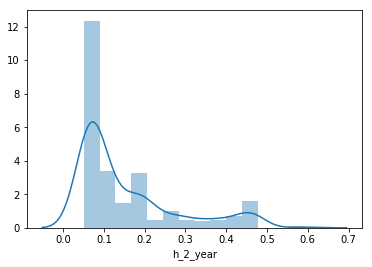

In [182]:
sns.distplot(df1['h_2_year'])
plt.show()

In [183]:
ids

{'23-57-94',
 '23-63-54',
 '23-70-47',
 '24-01-43',
 '24-01-98',
 '26-46-06',
 '28-65-17',
 '35-94-49',
 '36-45-33',
 '37-08-84',
 '40-46-21',
 '40-58-32',
 '42-09-10',
 '42-66-71',
 '43-39-15',
 '44-45-04',
 '48-13-54',
 '48-17-77',
 '48-28-80',
 '49-52-80',
 '51-48-91',
 '51-83-68',
 '51-83-83',
 '53-51-47',
 '54-28-53',
 '54-66-84',
 '55-09-28',
 '55-13-79',
 '56-43-18',
 '57-55-94',
 '57-80-27',
 '58-03-56',
 '58-13-12',
 '58-35-96',
 '58-42-87',
 '58-47-49',
 '58-49-88',
 '58-56-27',
 '58-78-78',
 '58-84-57',
 '58-84-63',
 '59-12-95',
 '59-19-81',
 '59-31-11',
 '59-40-48',
 '59-43-54',
 '59-45-68',
 '59-49-63',
 '59-51-52',
 '59-54-08',
 '59-55-10',
 '59-61-95',
 '59-66-61',
 '59-68-08',
 '59-69-09',
 '59-69-81',
 '59-71-30',
 '59-71-73',
 '59-73-45',
 '59-74-31',
 '59-76-33',
 '59-86-46',
 '59-88-97',
 '59-90-39',
 '59-91-63',
 '59-93-71',
 '59-95-63',
 '59-96-09',
 '59-97-09',
 '59-97-37',
 '60-02-64',
 '60-02-88',
 '60-06-72',
 '60-06-82',
 '60-10-41',
 '60-14-41',
 '60-16-51',